<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C2/W1/ungraded_lab/C2_W1_Lab_1_cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   Explore the example data of `Dogs vs. Cats`
2.   Build and train a neural network to classify between the two pets
3.   Evaluate the training and validation accuracy

## Download and Inspect the Dataset

We will start by downloading the dataset. This is a `.zip` of 2,000 JPG pictures of cats and dogs.

In [1]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-03-06 03:51:11--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  47.0MB/s    in 1.4s    

2022-03-06 03:51:13 (47.0 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



We will then extract it to the current directory.

In [2]:
import zipfile

# Unzip the archive
local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

The contents of the .zip are extracted to the base directory `./cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets.

These subdirectories in turn each contain `cats` and `dogs` subdirectories.

In [4]:
import os

base_dir = 'cats_and_dogs_filtered'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/validation'))

Contents of base directory:
['vectorize.py', 'train', 'validation']

Contents of train directory:
['dogs', 'cats']

Contents of validation directory:
['dogs', 'cats']


We can assign each of these directories to a variable so we can use it later.

In [41]:
import os

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


Now see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [42]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [43]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


For both cats and dogs, we have 1,000 training images and 500 validation images.

Now take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the `matplotlib` parameters:

In [44]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

Now, display a batch of 8 cat and 8 dog pictures

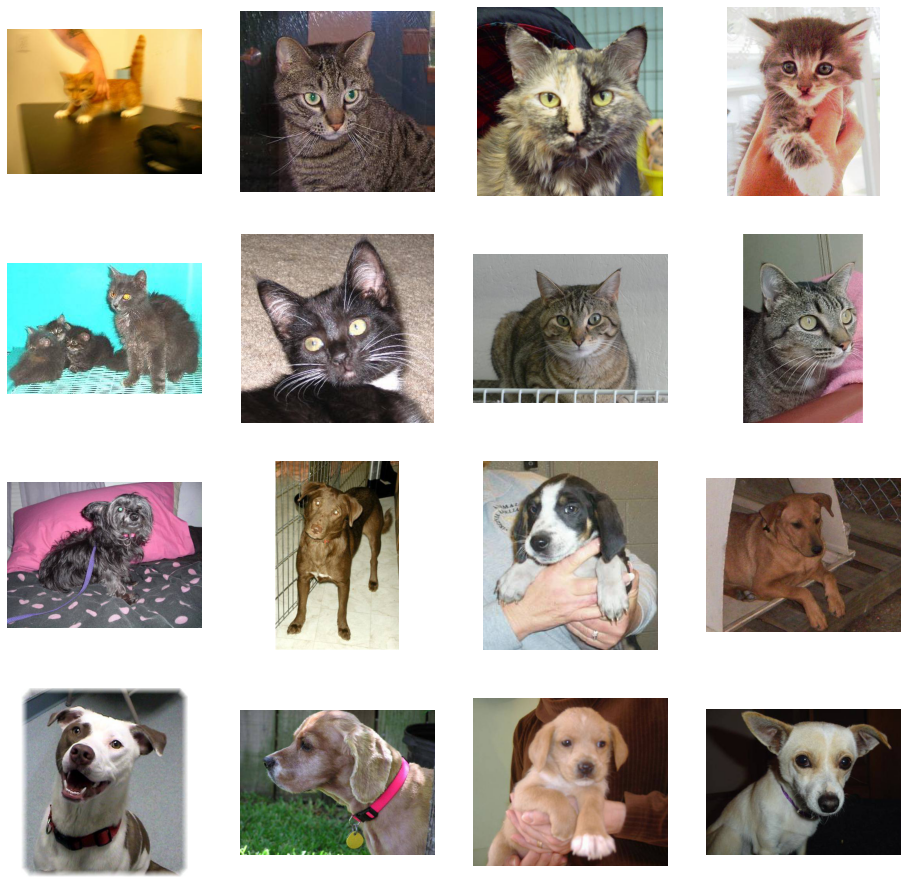

In [45]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


It may not be obvious from looking at the images in this grid but an important note here is that these images come in all shapes and sizes. So before training a neural network with them, we'll need to tweak the images.

## Building a Small Model from Scratch to get to ~72% Accuracy

To train a neural network to handle the images, we'll need them to be in a uniform size. We will choose 150x150 pixels for this, and we'll see the code that preprocesses the images to that shape shortly. 

We can define the model by importing Tensorflow and using the Keras API.


In [56]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

We defined a `Sequential` layer as before, adding some convolutional layers first. Note the `input_shape` parameter this time. Here is where we put the `150x150` size and `3` for the color depth because we have colored images. We then add a couple of convolutional layers and flatten the final result to feed into the densely connected layers.

We will end the network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function). The output of the network will be a single scalar between `0` and `1`, encoding the probability that the current image is class `1` (as opposed to class `0`).

We can review the architecture of the network with the `model.summary()` method: 

In [57]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 64)      

The `output_shape` column shows how the size of our feature map evolves in each successive layer. The convolution operation removes the outermost pixels from the original dimensions, and each pooling layer halves it.

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. We will use the `rmsprop` optimizer with a learning rate of `0.001`.

In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [58]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

### Data Preprocessing

Next step is to set up the data generators that will read pictures in the source folders, convert them to `float32` tensors, and feed them (with their labels) to the model. We'll have one generator for the training images and one for the validation images. These generators will yield batches of images of size 300x300 and their labels (binary).

We will preprocess the images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras, this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows us to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`.

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training
We will now train on all 2,000 images available, for 15 epochs, and monitor the accuracy as well on the 1,000 images in the validation set.

Do note the values per epoch.

We'll see 4 values per epoch -- Loss, Accuracy, Validation Loss and Validation Accuracy. 

The `loss` and `accuracy` are great indicators of progress in training. `loss` measures the current model prediction against the known labels, calculating the result. `accuracy`, on the other hand, is the portion of correct guesses. 


In [60]:
history = model.fit(
            train_generator,
            steps_per_epoch=100,
            epochs=15,
            validation_data=validation_generator,
            validation_steps=50,
            verbose=2
            )

Epoch 1/15
100/100 - 15s - loss: 0.7116 - accuracy: 0.5245 - val_loss: 0.6874 - val_accuracy: 0.6010 - 15s/epoch - 152ms/step
Epoch 2/15
100/100 - 14s - loss: 0.6805 - accuracy: 0.6005 - val_loss: 0.6310 - val_accuracy: 0.6600 - 14s/epoch - 142ms/step
Epoch 3/15
100/100 - 15s - loss: 0.6276 - accuracy: 0.6525 - val_loss: 0.6306 - val_accuracy: 0.6440 - 15s/epoch - 146ms/step
Epoch 4/15
100/100 - 14s - loss: 0.5560 - accuracy: 0.7220 - val_loss: 0.5743 - val_accuracy: 0.7170 - 14s/epoch - 141ms/step
Epoch 5/15
100/100 - 14s - loss: 0.5129 - accuracy: 0.7575 - val_loss: 0.5951 - val_accuracy: 0.7040 - 14s/epoch - 135ms/step
Epoch 6/15
100/100 - 14s - loss: 0.4574 - accuracy: 0.7825 - val_loss: 0.5878 - val_accuracy: 0.7240 - 14s/epoch - 136ms/step
Epoch 7/15
100/100 - 14s - loss: 0.4030 - accuracy: 0.8100 - val_loss: 0.5749 - val_accuracy: 0.7350 - 14s/epoch - 136ms/step
Epoch 8/15
100/100 - 13s - loss: 0.3339 - accuracy: 0.8510 - val_loss: 0.6566 - val_accuracy: 0.7490 - 13s/epoch - 129

### Model Prediction

Now take a look at actually running a prediction using the model. This code will allow us to choose 1 or more files from our file system, upload them, and run them through the model, giving an indication of whether the object is a cat or a dog.

In [61]:
import numpy as np

#from google.colab import files
from keras.preprocessing import image

#uploaded=files.upload()

#for fn in uploaded.keys():
fn =  '3.jpg'
# predicting images
path='D:\\Teach_n_Train\\Advanced_Lessons_CV\\LABS\\cnn_binary\\cats_and_dogs\\validation\\3.jpg'
img=image.load_img(path, target_size=(150, 150))

x=image.img_to_array(img)
x /= 255
x=np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images, batch_size=10)

print(classes[0])

if classes[0]>0.5:
    print(fn + " is a dog" )
else:
    print(fn + " is a cat" )
    


[0.00165942]
3.jpg is a cat


### Visualizing Intermediate Representations

To get a feel for what kind of features the CNN has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the model.

We can pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

<ipython-input-62-974d03ebecfd>:48: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


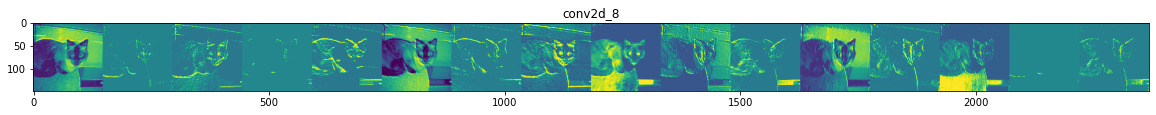

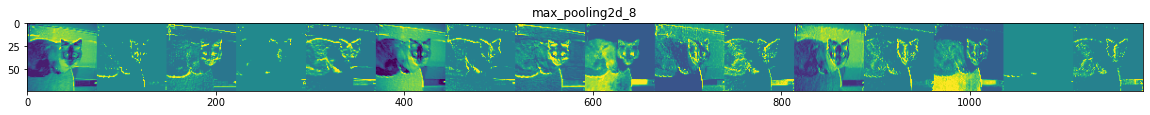

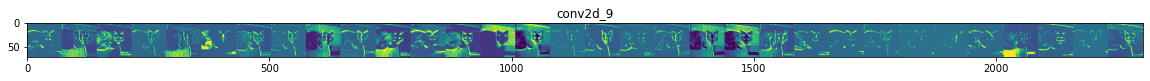

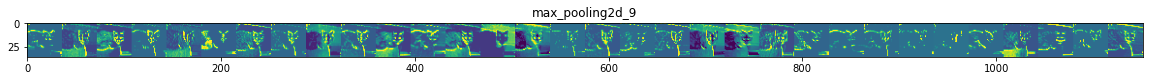

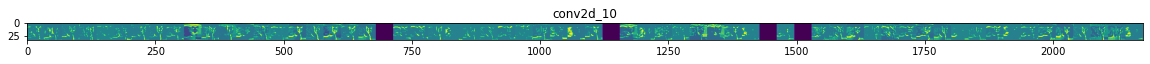

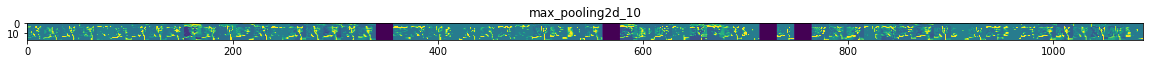

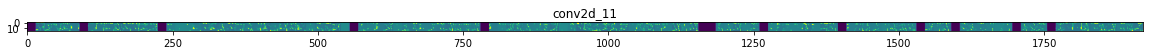

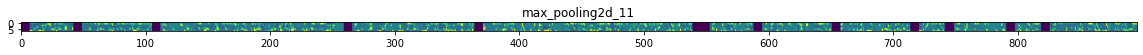

In [62]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so we can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

We can see above how the pixels highlighted turn to increasingly abstract and compact representations, especially at the bottom grid. 

The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called _representation sparsity_ and is a key feature of deep learning. These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. We can think of a convnet (or a deep network in general) as an information distillation pipeline wherein each layer filters out the most useful features.

### Evaluating Accuracy and Loss for the Model

We will plot the training/validation accuracy and loss as collected during training:

Text(0.5, 1.0, 'Training and validation loss')

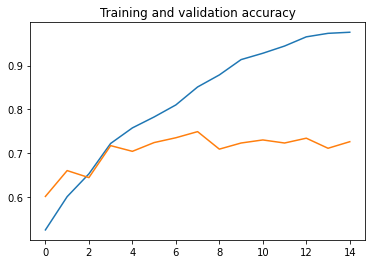

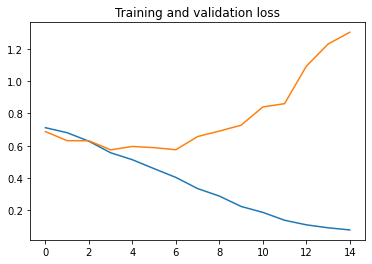

In [63]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

As you can see, the model is **overfitting**. The training accuracy (in blue) gets close to 100% while the validation accuracy (in orange) stalls as 70%. The validation loss reaches its minimum after only five epochs.

Since we have a relatively small number of training examples (2000), overfitting should be the number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data.